# Predicting Customer Churn

### Import libraries

In [97]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.tools.tools import add_constant

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_curve, roc_auc_score, recall_score)
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier

### Explore and clean data

In [2]:
churn_data = pd.read_csv('Churn_Modeling.csv', index_col=0)

In [3]:
churn_data

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1


In [4]:
# check for null values
churn_data.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
data_for_modeling = churn_data.drop(columns=['CustomerId', 'Surname'])

In [6]:
data_for_modeling

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9996,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9997,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9998,709,France,Female,36,7,0.00,1,0,1,42085.58,1


In [7]:
data_for_modeling.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [8]:
# check for duplicates
data_for_modeling.drop_duplicates(inplace=True)

In [9]:
data_for_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 937.5+ KB


In [10]:
# get dummy variables (need only numeric data for logistic regression)
data_for_modeling = pd.get_dummies(data_for_modeling, drop_first=True)

In [11]:
data_for_modeling.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
2,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
3,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
4,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
5,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


### Visualize data distribution

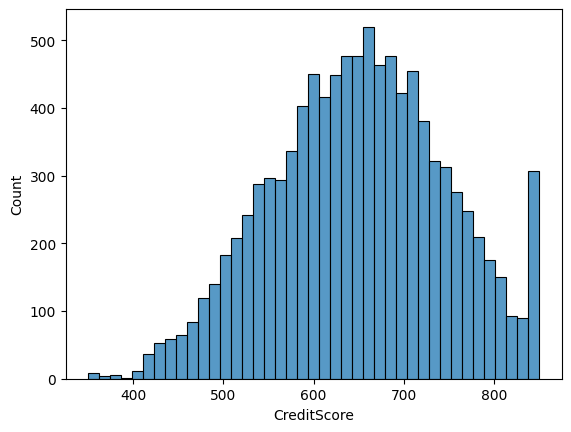

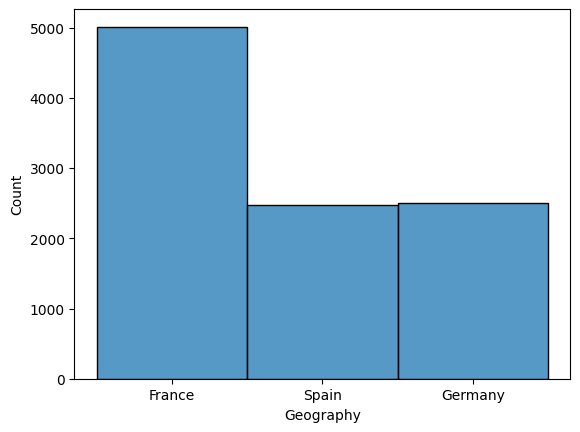

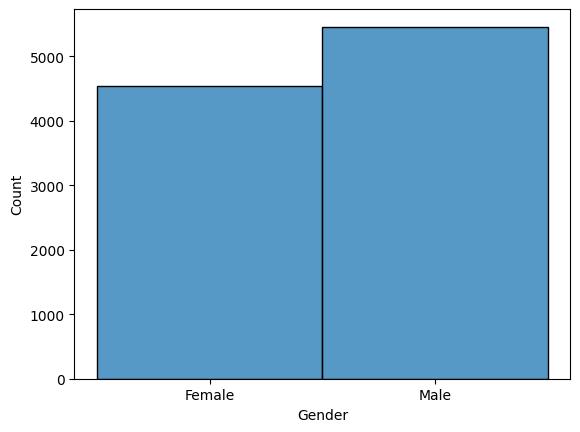

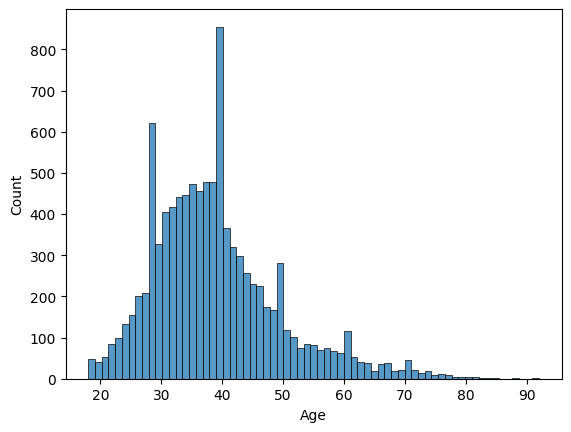

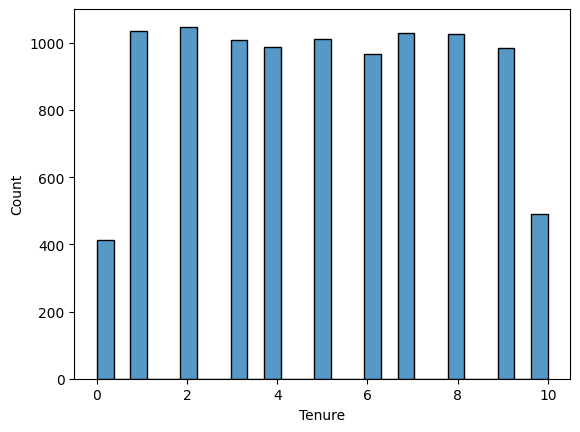

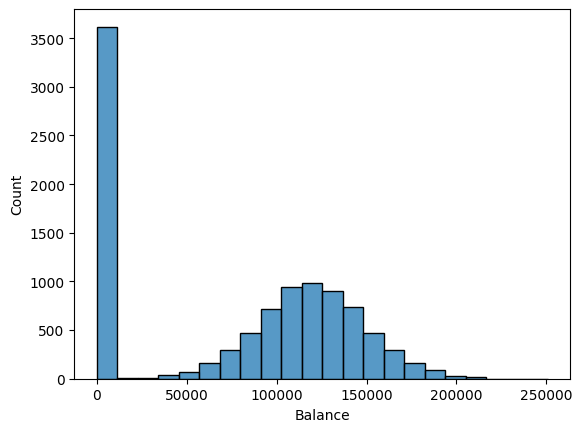

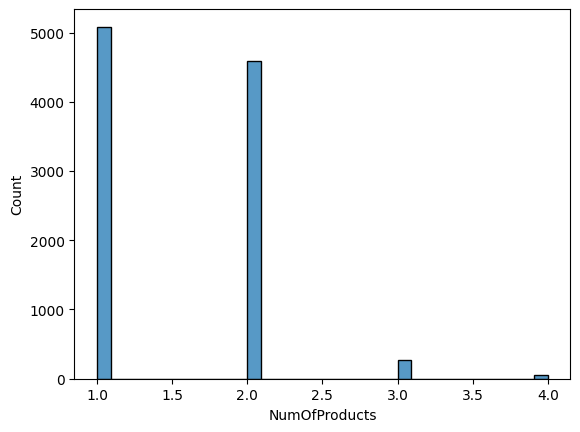

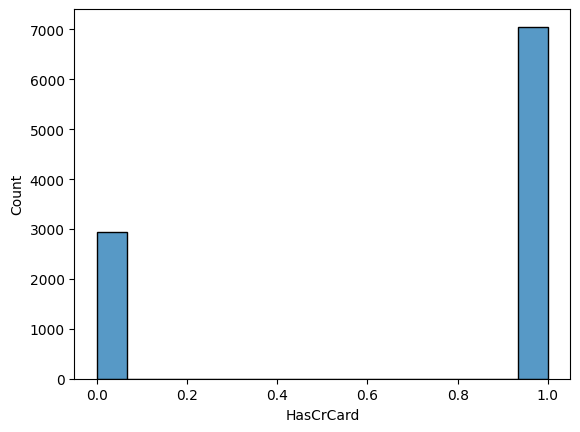

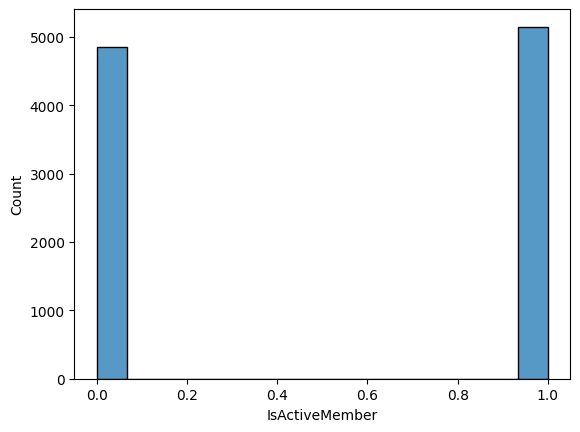

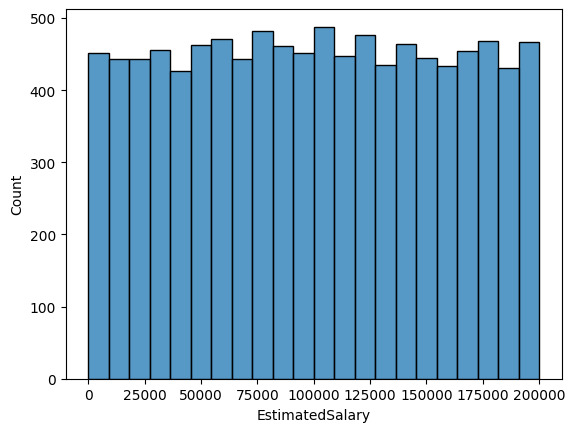

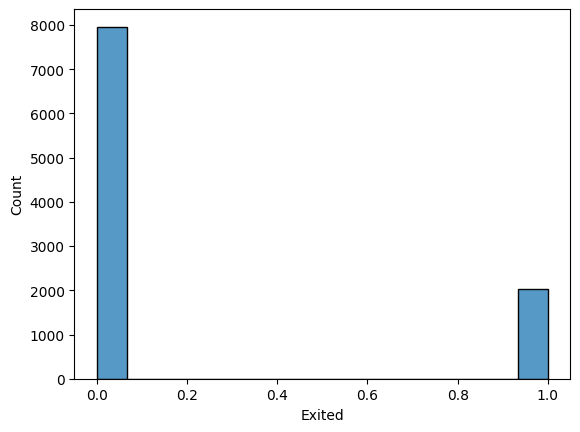

In [12]:
# visualizing distribution of numeric data to check for outliers

visualize_cols = ['CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited']

for col in visualize_cols:
    sns.histplot(data=churn_data, x=col)
    plt.show()

### Distribution by category (exited or not)

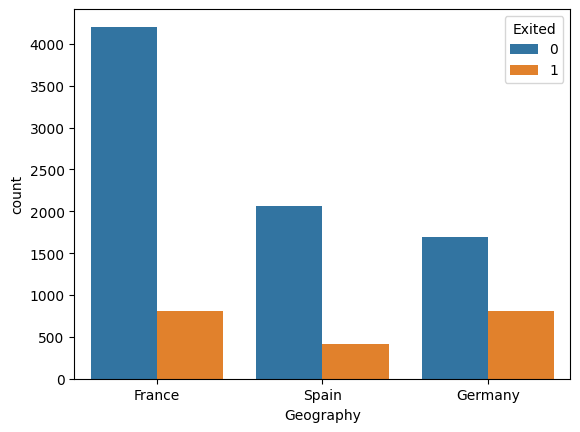

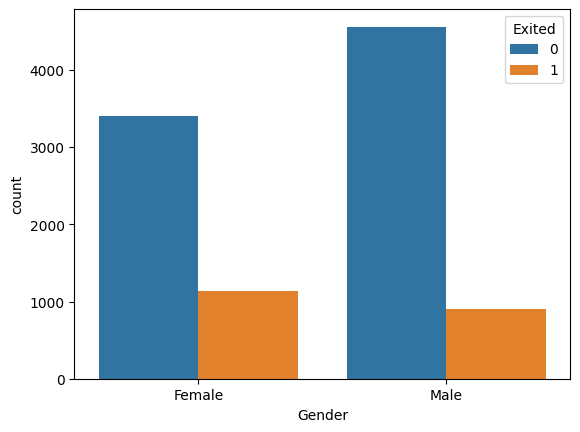

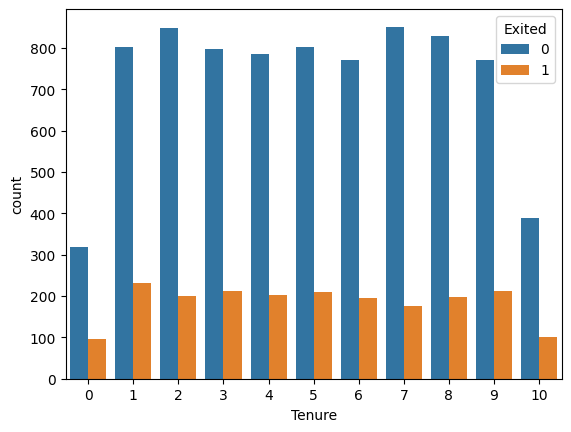

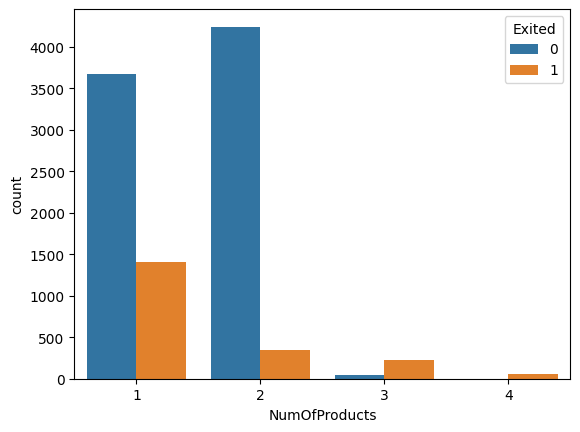

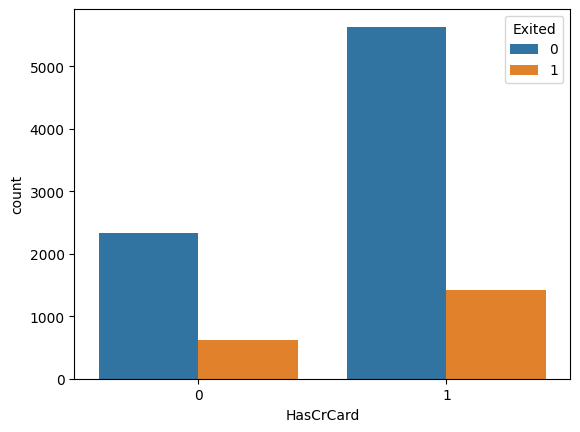

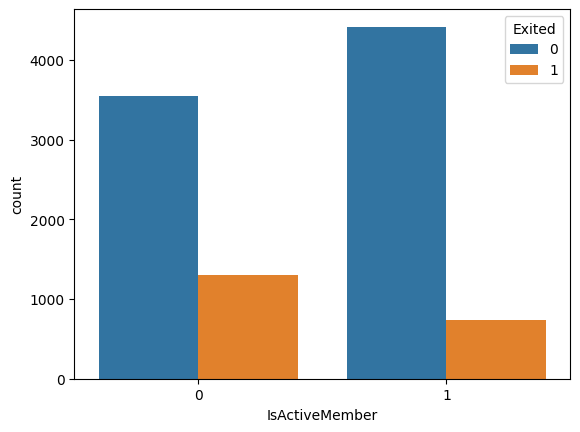

<Figure size 640x480 with 0 Axes>

In [13]:
bivariate_viz = ['Geography', 'Gender',
       'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

for col in bivariate_viz:
    sns.countplot(data=churn_data, x=col, hue='Exited')
    plt.show()
    plt.clf()

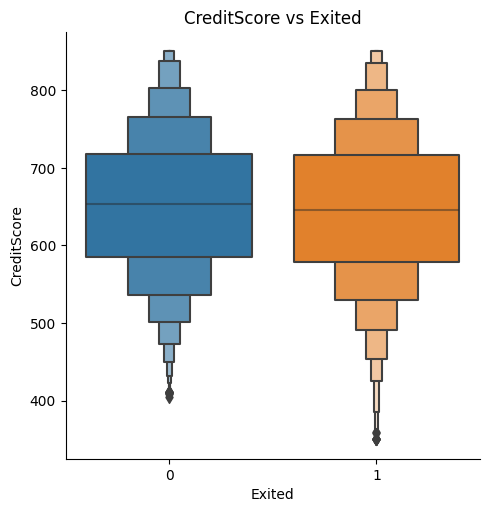

<Figure size 640x480 with 0 Axes>

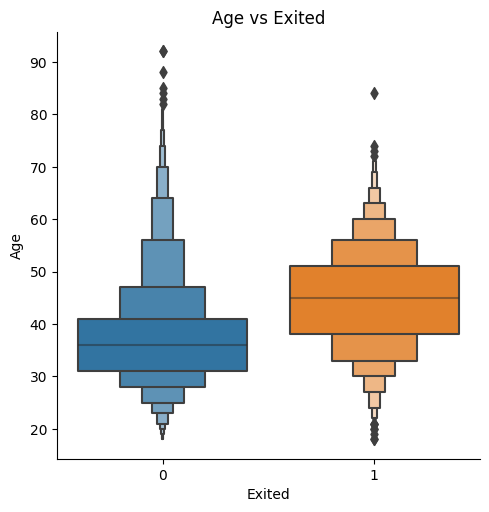

<Figure size 640x480 with 0 Axes>

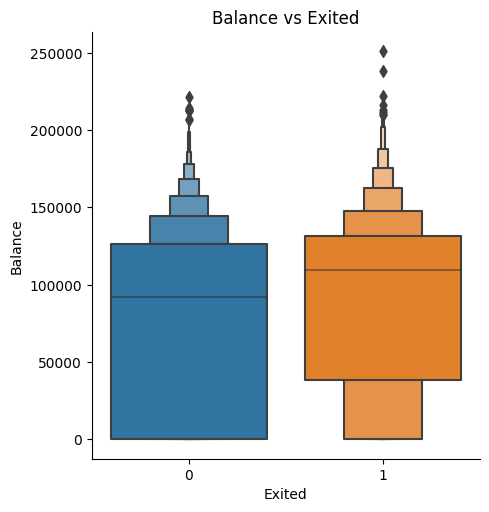

<Figure size 640x480 with 0 Axes>

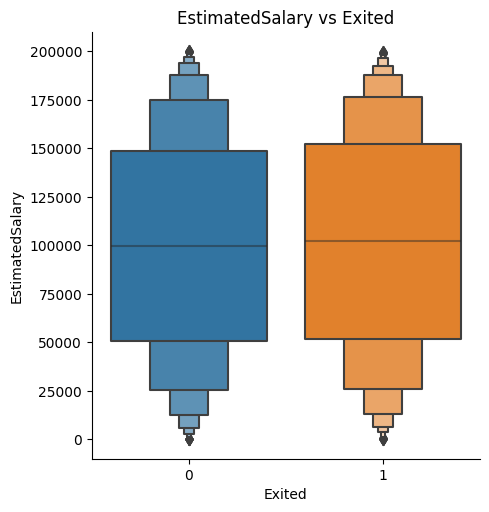

<Figure size 640x480 with 0 Axes>

In [14]:
col_box = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

for col in col_box:
    sns.catplot(churn_data, x='Exited', y=col, kind='boxen')
    plt.title(f'{col} vs Exited')
    plt.show()
    plt.clf()

### Check correlation matrix

In [15]:
correlation_matrix = data_for_modeling.corr(numeric_only=True)
correlation_matrix = round(correlation_matrix, 2)

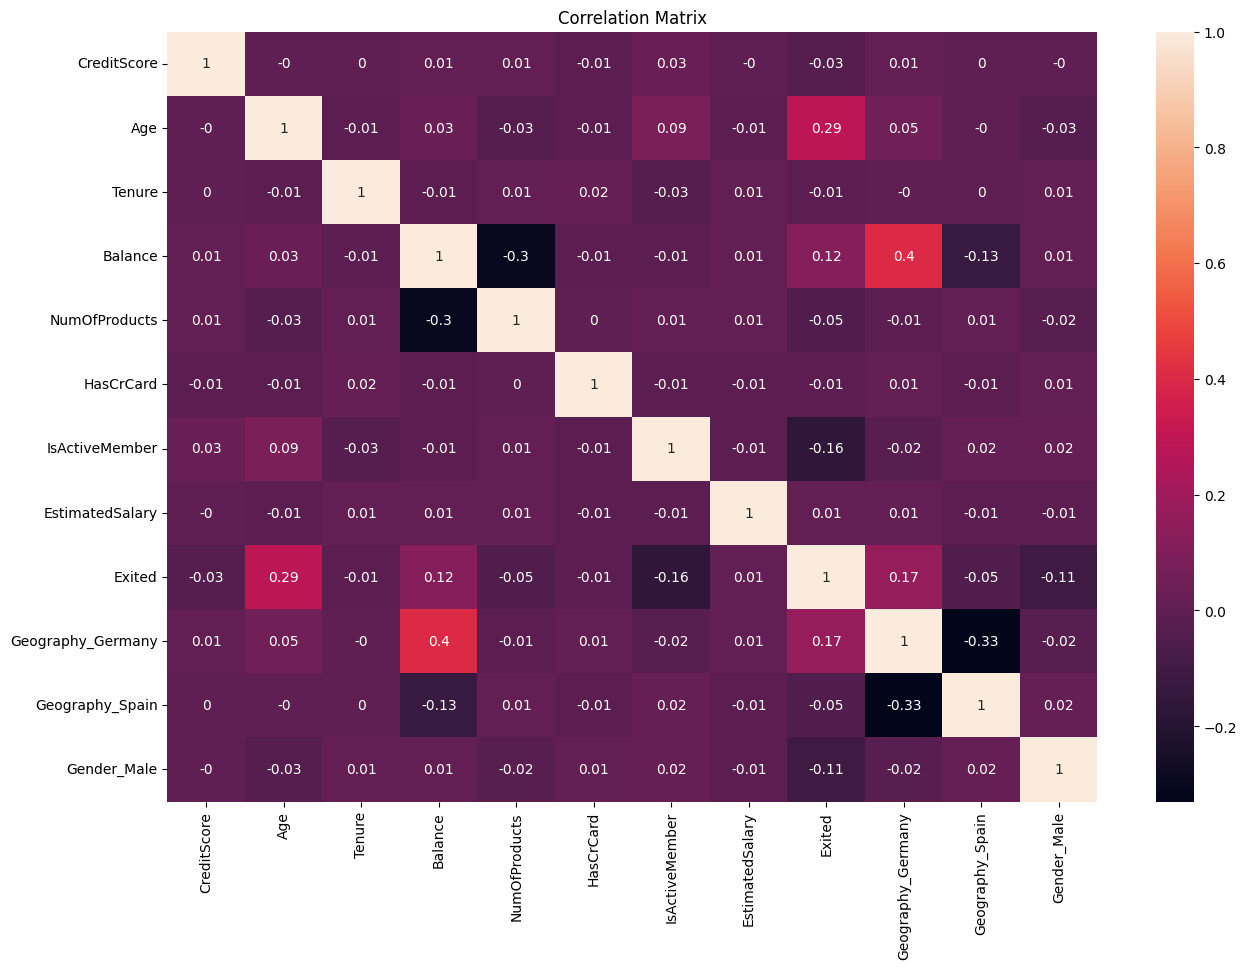

<Figure size 640x480 with 0 Axes>

In [16]:
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, )
plt.title('Correlation Matrix')
plt.show()
plt.clf()

### Select predictor / target variables

In [131]:
# Establish target feature, churn
y = data_for_modeling['Exited']
# Drop the target feature from remaining features
X = data_for_modeling.drop(columns=['Exited'])

### Variance Inflation Factor

As seen in the correlation matrix above, some features are more correlated with each other than I would like. The VIF scores below are another measure of correlation between variables. I want to keep CreditScore and Age as these are the most correlated with the target variable, "Exited". I will do a Box-Tidwell test to see if any other features should be removed first.

In [132]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

              feature        VIF
0         CreditScore  21.236445
1                 Age  12.334128
2              Tenure   3.872755
3             Balance   3.182267
4       NumOfProducts   7.826417
5           HasCrCard   3.289605
6      IsActiveMember   2.075966
7     EstimatedSalary   3.887186
8   Geography_Germany   1.787170
9     Geography_Spain   1.486247
10        Gender_Male   2.168988


### Box-Tidwell Test
This tests whether the residuals have a linear relationship with the logit, which is an assumption or condition for logistic regression.

In [133]:
X_continuous_numeric = data_for_modeling[['CreditScore', 'Age', 'Balance', 'Exited']]

# Box Tidwell only works for positive values. Hence, drop values where x = 0
X_bt = X_continuous_numeric[X_continuous_numeric['CreditScore'] != 0]
X_bt = X_bt[X_bt['Age'] != 0]
X_bt = X_bt[X_bt['Balance'] != 0]

X_bt.head()

,CreditScore,Age,Balance,Exited
RowNumber,,,,
2,608,41,83807.86,0
3,502,42,159660.80,1
5,850,43,125510.82,0
6,645,44,113755.78,1
8,376,29,115046.74,1


In [134]:
X_bt2 = X_bt.drop(columns=['Exited'])
y_bt = X_bt['Exited']

# Add logit transform interaction terms (natural log) for continuous variables e.g. Age * Log(Age)
for col in X_bt2.columns:
    X_bt2[f'{col}:Log_{col}'] = X_bt2[col].apply(lambda x: x * np.log(x)) #np.log = natural log

X_bt2.head()

,CreditScore,Age,Balance,CreditScore:Log_CreditScore,Age:Log_Age,Balance:Log_Balance
RowNumber,,,,,,
2,608,41,83807.86,3897.386328,152.256455,9.500695e+05
3,502,42,159660.80,3121.737260,156.982124,1.912865e+06
5,850,43,125510.82,5733.450897,161.731605,1.473516e+06
6,645,44,113755.78,4172.666454,166.504344,1.324323e+06
8,376,29,115046.74,2229.525518,97.651579,1.340650e+06


In [135]:
# Add constant
X_bt_constant = add_constant(X_bt2)
  
# Build model and fit the data (using statsmodel's Logit)
logit_results = GLM(y_bt, X_bt_constant, family=families.Binomial()).fit()

# Display summary results
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Exited   No. Observations:                 6383
Model:                            GLM   Df Residuals:                     6376
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3134.4
Date:                Sun, 25 Jun 2023   Deviance:                       6268.7
Time:                        22:19:57   Pearson chi2:                 7.86e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1148
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

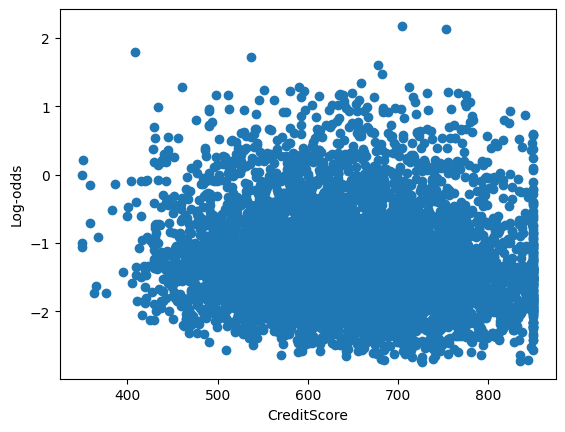

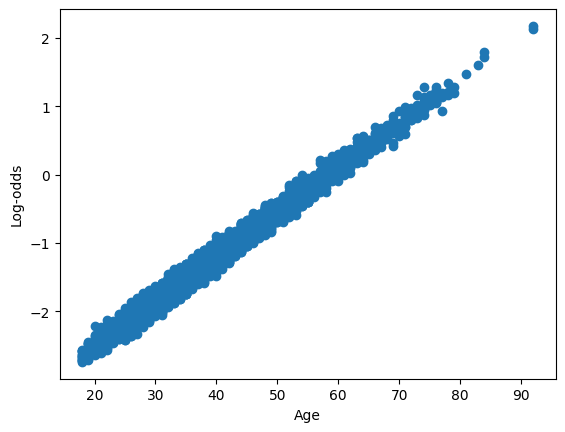

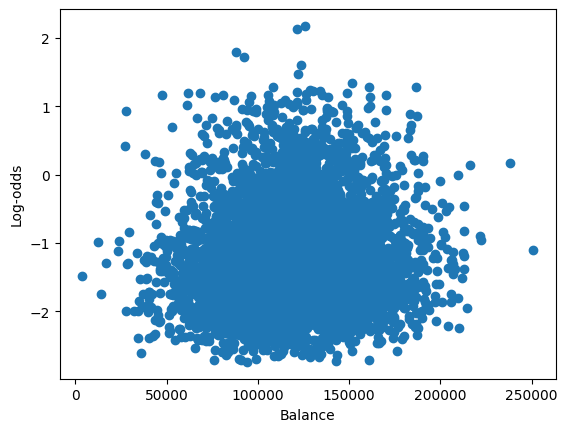

In [136]:
X_bt3 = X_bt.drop(columns=['Exited'])
y_bt3 = X_bt['Exited']
# Add constant
X_bt3_constant = add_constant(X_bt3)

# Re-running logistic regression on the original set of X and y variables (not log transformed)
logit_results = GLM(y_bt3, X_bt3_constant, family=families.Binomial()).fit()
predicted3 = logit_results.predict(X_bt3_constant)

# Getting log odds values
log_odds = np.log(predicted3 / (1 - predicted3))

cols = ['CreditScore', 'Age', 'Balance']
for col in cols:
    # Visualize predictor variable vs logit values for Age
    plt.scatter(x=X_bt3_constant[col].values, y=log_odds)
    plt.xlabel(col)
    plt.ylabel("Log-odds")
    plt.show()

CreditScore and Balance both clearly do not meet this assumption, there is no linear relationship seen.

In [137]:
# drop d/t assumption not met
X.drop(columns=['CreditScore', 'Balance'], inplace=True)

### Check VIF after dropping features
Now the VIF scores are much lower.

In [138]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

             feature       VIF
0                Age  8.651229
1             Tenure  3.672311
2      NumOfProducts  6.197905
3          HasCrCard  3.150549
4     IsActiveMember  2.048745
5    EstimatedSalary  3.664956
6  Geography_Germany  1.485841
7    Geography_Spain  1.470673
8        Gender_Male  2.108638


### Scale data

In [139]:
# scale data
scaler = MinMaxScaler().set_output(transform="pandas")
X = pd.DataFrame(scaler.fit_transform(X))

### Train test split

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### Set up model

In [141]:
# Instantiate a logistic regression model without an intercept, arbitrarily large C value will offset the lack of intercept
logreg = LogisticRegression(fit_intercept = False, C = 1e12, solver = 'liblinear', random_state=42)

# Fit the model to our X and y training sets
logreg.fit(X_train, y_train)

LogisticRegression(C=1000000000000.0, fit_intercept=False, random_state=42,
                   solver='liblinear')

### Evaluate Model

In [142]:
def Evaluate(model_name):
    #Accuracy on train
    print('The training accuracy is: ', model_name.score(X_train, y_train))

    #Accuracy on test
    print('The testing accuracy is: ', model_name.score(X_test, y_test))

    #Classification report
    yhat = model_name.predict(X_test)
    print(classification_report(y_test, yhat, zero_division=0))

    #log loss on test set
    pred_proba = model_name.predict_proba(X_test)
    print('The log loss on testing dataset is: ', log_loss(y_test, pred_proba, normalize='true'))

    print(f'Accuracy Score: {accuracy_score(y_test,yhat)}')
    print(f'Area Under Curve: {roc_auc_score(y_test, yhat)}')
    print(f'Recall score: {recall_score(y_test,yhat)}')

In [143]:
Evaluate(logreg)

The training accuracy is:  0.8024285714285714
The testing accuracy is:  0.806
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      2416
           1       0.50      0.20      0.29       584

    accuracy                           0.81      3000
   macro avg       0.67      0.58      0.59      3000
weighted avg       0.77      0.81      0.77      3000

The log loss on testing dataset is:  0.4461932048790976
Accuracy Score: 0.806
Area Under Curve: 0.5776699854848952
Recall score: 0.20376712328767124


In [144]:
def plot_confusion_matrix(model_name):
    # get class predictions
    yhat = model_name.predict(X_test)
    yhat_round = list(map(round, yhat))

    # confusion matrix
    cm = confusion_matrix(y_test, yhat_round, normalize='true') 
    print ("Confusion Matrix : \n", cm) 
    
    # accuracy score of the model
    print('Test accuracy = ', accuracy_score(y_test, yhat_round))

    sns.heatmap(cm, cmap='YlGnBu', annot=True)
    plt.title('Confusion Matrix')
    plt.show()
    plt.clf()

Confusion Matrix : 
 [[0.95157285 0.04842715]
 [0.79623288 0.20376712]]
Test accuracy =  0.806


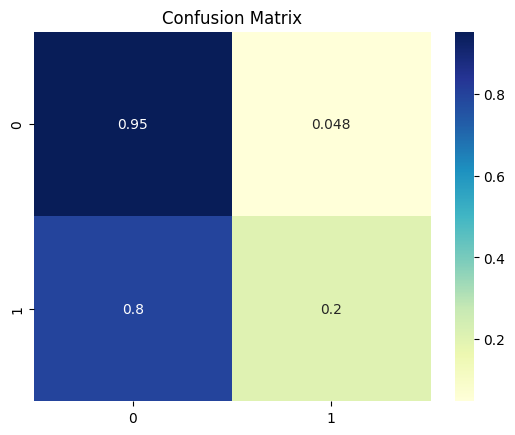

<Figure size 640x480 with 0 Axes>

In [145]:
plot_confusion_matrix(logreg)

In [162]:
def plot_auc_roc_curve(model_name):
    #define metrics
    y_pred_proba = model_name.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

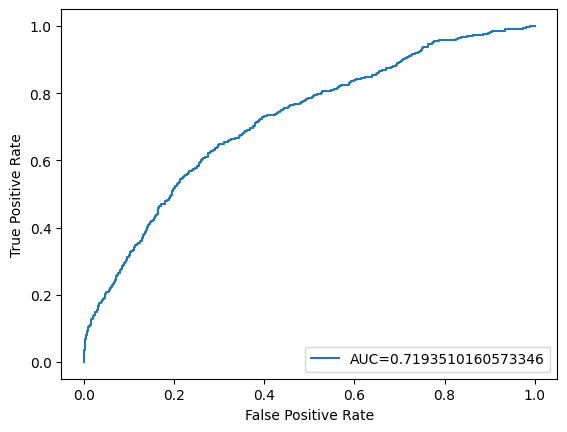

In [163]:
plot_auc_roc_curve(logreg)

### Feature importance

In [146]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=42, class_weight='balanced', max_depth=10)
dt.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, random_state=42)

In [147]:
fi_col = []
fi = []

for i, column in enumerate(X.columns):
    print('The feature importance for {} is {}: '.format(column, dt.feature_importances_[i]))

    fi_col.append(column)
    fi.append(dt.feature_importances_[i])

The feature importance for Age is 0.366785000000576: 
The feature importance for Tenure is 0.05248898167144932: 
The feature importance for NumOfProducts is 0.2413672272739718: 
The feature importance for HasCrCard is 0.012159022932869728: 
The feature importance for IsActiveMember is 0.0716954287597841: 
The feature importance for EstimatedSalary is 0.17858255190255515: 
The feature importance for Geography_Germany is 0.039117582161433156: 
The feature importance for Geography_Spain is 0.01125390391327508: 
The feature importance for Gender_Male is 0.026550301384085612: 


### Calculate weights

In [148]:
y.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [149]:
exited_weight = 2037/7963
exited_weight

0.25580811252040686

### Try model with weights based on data distribution

In [150]:
# define class weights
w = {0:1, 1:4}
# define model
logreg2 = LogisticRegression(fit_intercept = False, C = 1e12, solver = 'liblinear', random_state=42, class_weight=w)

# Fit the model 
logreg2.fit(X_train, y_train)

LogisticRegression(C=1000000000000.0, class_weight={0: 1, 1: 4},
                   fit_intercept=False, random_state=42, solver='liblinear')

### Evaluate

In [151]:
Evaluate(logreg2)

The training accuracy is:  0.6708571428571428
The testing accuracy is:  0.6633333333333333
              precision    recall  f1-score   support

           0       0.91      0.65      0.76      2416
           1       0.33      0.72      0.46       584

    accuracy                           0.66      3000
   macro avg       0.62      0.69      0.61      3000
weighted avg       0.79      0.66      0.70      3000

The log loss on testing dataset is:  0.6174138737748882
Accuracy Score: 0.6633333333333333
Area Under Curve: 0.6858046811212919
Recall score: 0.7226027397260274


Confusion Matrix : 
 [[0.64900662 0.35099338]
 [0.27739726 0.72260274]]
Test accuracy =  0.6633333333333333


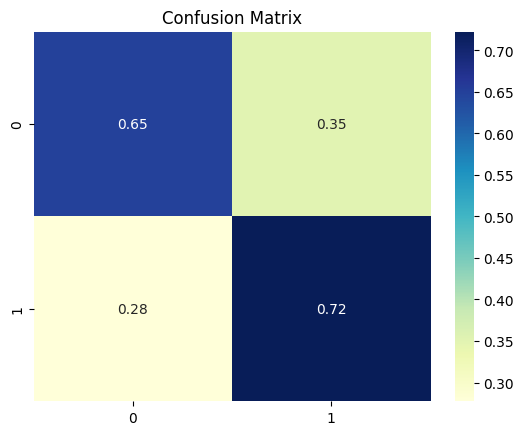

<Figure size 640x480 with 0 Axes>

In [152]:
plot_confusion_matrix(logreg2)

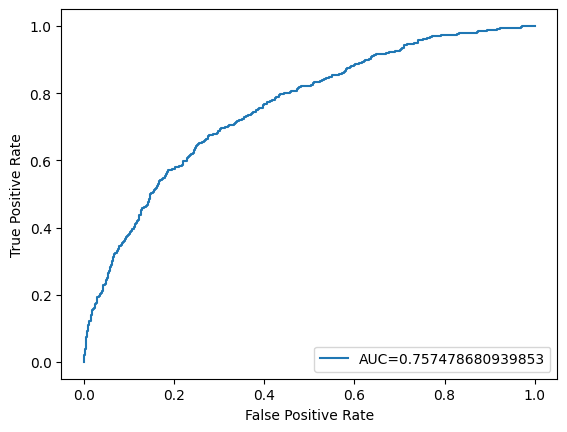

In [164]:
plot_auc_roc_curve(logreg2)

### Try gridsearch to find best model weights

In [153]:
# define weight hyperparameter
w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
hyperparam_grid = {"class_weight": w }

In [154]:
# define model
lg3 = LogisticRegression(fit_intercept = False, C = 1e12, solver = 'liblinear', random_state=42)
# define evaluation procedure
grid = GridSearchCV(lg3,hyperparam_grid,scoring="roc_auc", cv=100, n_jobs=-1, refit=True)
grid.fit(X,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.7655100889089813 with param: {'class_weight': {0: 1.0, 1: 10}}


### Evaluate

In [155]:
# define model
logreg3 = LogisticRegression(fit_intercept = False, C = 1e12, solver = 'liblinear', random_state=42, class_weight={0: 1.0, 1: 10})
# fit it
logreg3.fit(X_train,y_train)
# test

Evaluate(logreg3)

The training accuracy is:  0.43785714285714283
The testing accuracy is:  0.42966666666666664
              precision    recall  f1-score   support

           0       0.95      0.31      0.46      2416
           1       0.25      0.94      0.39       584

    accuracy                           0.43      3000
   macro avg       0.60      0.62      0.43      3000
weighted avg       0.82      0.43      0.45      3000

The log loss on testing dataset is:  0.9209757458555462
Accuracy Score: 0.42966666666666664
Area Under Curve: 0.6218815204572259
Recall score: 0.9366438356164384


Confusion Matrix : 
 [[0.30711921 0.69288079]
 [0.06335616 0.93664384]]
Test accuracy =  0.42966666666666664


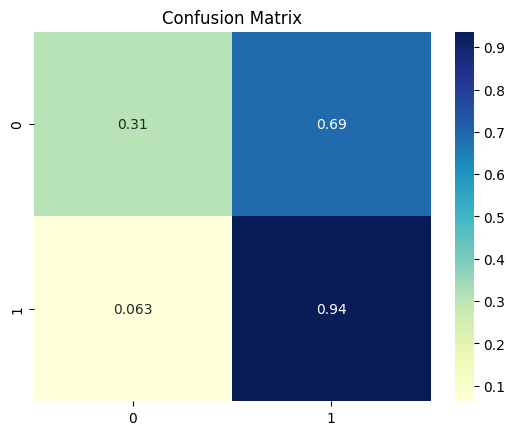

<Figure size 640x480 with 0 Axes>

In [156]:
plot_confusion_matrix(logreg3)

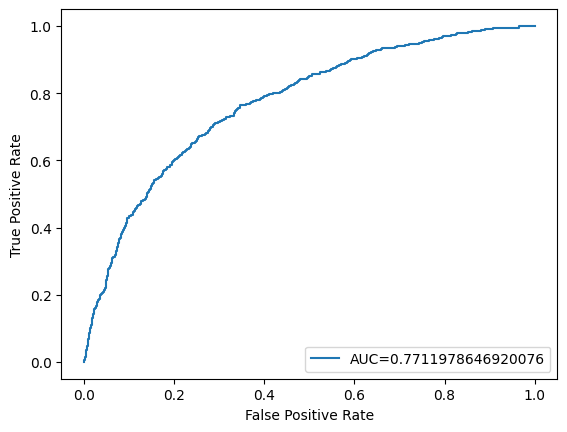

In [165]:
plot_auc_roc_curve(logreg3)

### Discussion
Each model has benefits and drawbacks. The first model was the most accurate (it got the predictions right the most often) but, unfortunately, it did that by predicting that nearly all the samples would not churn ("0" value for "Exited"). This doesn't actually help if the goal is to identify and intervene with customers likely to churn.

The second model with the weighted values did a nice job predicting both categories, with about 72% accuracy for customers that will churn and 65% accuracy for those that won't. Ideally the accuracy for customers that will churn would be higher, but there could be utility in striking a balance of mostly accurate predictions for both classes.

The third model is optimized for the best roc_auc score, and it does a great job predicting customers that will churn with 94% accuracy! The drawback here is that it also misclassifies 69% of customers that actually won't churn, which is a pretty high percentage. However, if the highest priority is to identify customers that are likely to churn, this model might be the best option of the three.

SOURCES: 
1. https://towardsdatascience.com/predicting-customer-churn-using-logistic-regression-c6076f37eaca
2. https://www.kaggle.com/datasets/shubh0799/churn-modelling
3. https://towardsdatascience.com/weighted-logistic-regression-for-imbalanced-dataset-9a5cd88e68b
4. https://www.statology.org/plot-roc-curve-python/